In [1]:
# IANNwTF_Homework 05 - cifar10 & CNN

import matplotlib.pyplot as plt
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

In [2]:
class Model(tf.keras.Model):
  
  def __init__(self):
    super(Model, self).__init__()
    DROPOUT_RATE = 0.05
    # Instantiate the layers of the networks
    self.conv_1 = tf.keras.layers.Conv2D(filters=256,
                                         kernel_size=3,
                                         padding="same",
                                         activation=None,
                                         input_shape=(32, 32, 3),
                                         kernel_regularizer="l2",
                                         bias_regularizer="l2"
                                         )
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()
    self.activation_1 = tf.keras.layers.Activation('relu')    
    self.dropout_1 = tf.keras.layers.Dropout(DROPOUT_RATE)
    self.max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1))
    self.conv_2 = tf.keras.layers.Conv2D(filters=64,
                                         kernel_size=3,
                                         strides=(2, 2),
                                         padding="same",
                                         activation=None,
                                         kernel_regularizer="l2",
                                         bias_regularizer="l2"
                                         )
    self.batch_norm_2 = tf.keras.layers.BatchNormalization()
    self.activation_2 = tf.keras.layers.Activation('relu')
    self.dropout_2 = tf.keras.layers.Dropout(DROPOUT_RATE)
    self.max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2))

    self.conv_3 = tf.keras.layers.Conv2D(filters=128,
                                         kernel_size=3,
                                         strides=(2, 2),
                                         padding="same",
                                         activation=None,
                                         kernel_regularizer="l2",
                                         bias_regularizer="l2"
                                         )
    self.batch_norm_3 = tf.keras.layers.BatchNormalization()
    self.activation_3 = tf.keras.layers.Activation('relu')
    self.dropout_3 = tf.keras.layers.Dropout(DROPOUT_RATE)
    self.max_pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2))

    




        
    self.global_pool = tf.keras.layers.GlobalAveragePooling2D(data_format="channels_last")

    self.output_layer = tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
    
  #@tf.function
  def call(self, x, training=True):
    # print(x.shape)
    # Define forward pass
    x = self.conv_1(x)
    x = self.batch_norm_1(x)
    x = self.activation_1(x)
    x = self.dropout_1(x, training)
    x = self.max_pool_1(x)
    # print(x.shape)
    x = self.conv_2(x)
    x = self.batch_norm_2(x)
    x = self.activation_2(x)
    x = self.dropout_2(x, training)
    x = self.max_pool_2(x)
    # print(x.shape)
    x = self.conv_3(x)
    x = self.batch_norm_3(x)
    x = self.activation_3(x)
    x = self.dropout_3(x, training)
    x = self.max_pool_3(x)
    # print(x.shape)





    x = self.global_pool(x)
    x = self.output_layer(x)
    # print(x.shape)
    return x

In [3]:
def train_step(model, input, target, loss_function, optimizer):
  # if using dropout, add: training=True
  with tf.GradientTape() as tape:
    # for dropout, use: prediction = model(input, training)
    prediction = model(input)
    loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  # if use dropout, add training=False
  test_losses = []
  test_accuracies = []
    
  for (input, target) in test_data:
    # prediction = model(input, training)
    prediction = model(input, False)
    sample_test_loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)
    
    # print('line 20: sample_test_loss is ', sample_test_loss)
    # axis=0 is the batch_size, axis=1 is the one-hot encoding of the labels
        
    sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    
    test_losses.append(sample_test_loss.numpy())
    # compute the sample_test_accuracy for each batch before appending
    test_accuracies.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_losses)
  test_accuracy = np.mean(test_accuracies)

  return test_loss, test_accuracy    

In [4]:
# visualize accuracy and loss for train_ds & test_ds
def plot(train_losses, test_losses, test_accuracies, figsize=(10,3)):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
  axes[0].plot(train_losses, label='train')
  axes[0].plot(test_losses, label='test')
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('Loss')
  axes[0].set_title('Loss', fontsize=20)
  axes[0].legend()
  axes[1].plot(test_accuracies)
  axes[1].set_xlabel('Epochs')
  axes[1].set_ylabel('Accuracy')
  plt.ylim(0,1.0)
  axes[1].set_title('Accuracy' + str(round(np.max(test_accuracies))), fontsize=20)
  plt.show()
  return fig

In [5]:
# implementation credits go to Group 16's Week04 homework
# option 1: gaussian standard distribution
def norm_std():
  return tf.image.per_image_standardization(image)

# option 2: normalize to (0,1)
def norm_0_1(x):
  max = 255
  min = 0
  result = tf.math.subtract(x, min)
  norm_image = tf.math.divide(result, (max - min))
  return norm_image

# option 3: normalize to (-1,1)
def norm_neg_1(x):
  result = norm_0_1(x)
  result = tf.math.multiply(result, 2)
  norm_image = tf.math.subtract(result, 1)
  return norm_image

### Load the Dataset


In [6]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
# train_ds, test_ds = tf.keras.datasets.cifar10.load_data()

# train_ds = train_ds[:10000]
# test_ds = test_ds[11000:15000]
# Here we take the first 10000 images for training, another 4000 images for testing
# as a starting point to build the whole pipeline 
# train_images = train_images[:2000]
# train_labels = train_labels[:200]
# test_images = test_images[:400]
# test_labels = test_labels[:400]


### Investigate the dataset

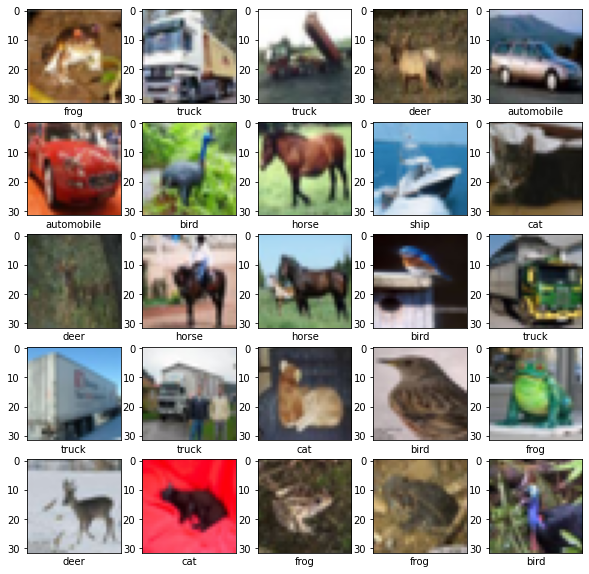

In [7]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.xticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.binary)
  plt.xlabel(class_names[train_labels[i][0]])
plt.show()


In [8]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)
print(np.max(train_images[0])) # --> max pixel value: 255
print(np.min(train_images[0]))

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)
255
0


In [9]:
# confirming the pixel range of the images: (0,255)
# this will be used for normalization
max = 0
min = 0 
for train_image in train_images:
  if np.max(train_image) > max:
    max = np.max(train_image)
  if np.min(train_image) < min:
    min = np.min(train_image)
print(max, min)

255 0


### Input Pipeline

In [10]:
# preprocess train_ds
# Unlike the previous homework, the current images have the same size --> no resizing needed
# Here only normalization of pixel values to (-1,1) and one-hot encoding the label are performed
train_ds_images = tf.data.Dataset.from_tensor_slices(train_images)
#train_ds_images = train_ds_images.map(lambda img : tf.reshape(img, (-1,)))
train_ds_images = train_ds_images.map(lambda image: norm_neg_1(image))
train_ds_labels = tf.data.Dataset.from_tensor_slices(train_labels)
train_ds_labels = train_ds_labels.map(lambda label : tf.one_hot(label, 10))
train_ds_labels = train_ds_labels.map(lambda label: tf.reshape(label, (-1,)))

# repeat the above procedures for test_ds
test_ds_images = tf.data.Dataset.from_tensor_slices(test_images)
test_ds_images = test_ds_images.map(lambda image: norm_neg_1(image))
test_ds_labels = tf.data.Dataset.from_tensor_slices(test_labels)
test_ds_labels = test_ds_labels.map(lambda label : tf.one_hot(label, 10))
test_ds_labels = test_ds_labels.map(lambda label: tf.reshape(label, (-1,)))
# print(test_ds_labels)


train_ds = tf.data.Dataset.zip((train_ds_images, train_ds_labels))
train_ds_shuffle = train_ds.shuffle(buffer_size=10000)
train_ds_batched = train_ds_shuffle.batch(64)
train_ds_total = train_ds_batched.prefetch(tf.data.experimental.AUTOTUNE)

# repeat the above procedures for test_ds
test_ds = tf.data.Dataset.zip((test_ds_images, test_ds_labels))
test_ds_shuffle = test_ds.shuffle(buffer_size=4000)
test_ds_batched = test_ds.batch(64)
test_ds_total = test_ds_batched.prefetch(tf.data.experimental.AUTOTUNE)

In [11]:
# Helper function to test the generated dataset from tensors
train_ds_images = tf.data.Dataset.from_tensor_slices(train_images)
print(train_ds_images)

<TensorSliceDataset shapes: (32, 32, 3), types: tf.uint8>


## Train

In [12]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 30
learning_rate = 0.0002
running_average_factor = 0.95

# Initialize the model
model = Model()
# Define the loss
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization
train_losses = []

test_losses = []
test_accuracies =[]

# testing once on test data before start
test_loss, test_accuracy = test(model, test_ds_total, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# check how model performs on train data once before start
train_loss, _ = test(model, train_ds_total, cross_entropy_loss)
train_losses.append(train_loss)

fig = ''
# Train for num_epochs
for epoch in range(num_epochs):
  # print('Epoch: ', str(epoch))

  # training
  running_average = 0
  for (sample, target) in train_ds_total:
    train_loss = train_step(model, sample, target, cross_entropy_loss, optimizer)
    running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
  # print('running average is ', running_average)
  train_losses.append(tf.get_static_value(running_average))

  # testing
  test_loss, test_accuracy = test(model, test_ds_total, cross_entropy_loss)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  print('Epoch: ', str(epoch),'Train loss:', tf.get_static_value(running_average) , 'Test loss:', test_loss, 'Test accuracy:', test_accuracy)
  
  # fig = plot(train_losses, test_losses, test_accuracies)

Epoch:  0 Train loss: 2.3508217 Test loss: 2.491333 Test accuracy: 0.5207006369426752
Epoch:  1 Train loss: 1.7704583 Test loss: 1.8124492 Test accuracy: 0.60828025477707
Epoch:  2 Train loss: 1.4061679 Test loss: 1.5125644 Test accuracy: 0.6321656050955414
Epoch:  3 Train loss: 1.2410529 Test loss: 1.3430256 Test accuracy: 0.6541600318471338
Epoch:  4 Train loss: 1.1060288 Test loss: 1.2277278 Test accuracy: 0.6731687898089171
Epoch:  5 Train loss: 1.0318422 Test loss: 1.1884679 Test accuracy: 0.661922770700637
Epoch:  6 Train loss: 0.9482032 Test loss: 1.2023728 Test accuracy: 0.6655055732484076
Epoch:  7 Train loss: 0.9174372 Test loss: 1.0631562 Test accuracy: 0.7084992038216561
Epoch:  8 Train loss: 0.9072252 Test loss: 1.1405513 Test accuracy: 0.6746616242038217
Epoch:  9 Train loss: 0.8487541 Test loss: 1.0632455 Test accuracy: 0.6971536624203821
Epoch:  10 Train loss: 0.8352742 Test loss: 1.0174502 Test accuracy: 0.7157643312101911
Epoch:  11 Train loss: 0.8311272 Test loss: 1.

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  7168      
_________________________________________________________________
batch_normalization (BatchNo multiple                  1024      
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  147520    
_________________________________________________________________
batch_normalization_1 (Batch multiple                  256   

## Alternative: Visualize Training progress 
### (the visualization has been integrated into the training process)

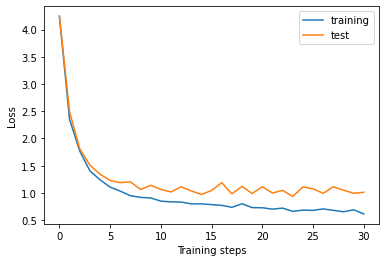

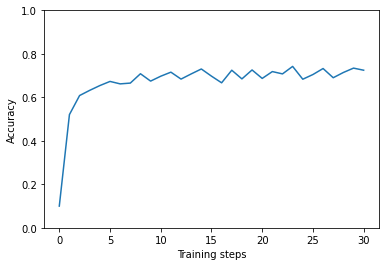

In [16]:
# upper plot: training and test losses
# lower plot: training and test accuracies

plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1, line2), ("training", "test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.ylim(0,1.0)
plt.show()

# ----------------------------------
# saving the model
# model.save_weights('malaria_cnn_conv3')